In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import tqdm as notebook_tqdm
import matplotlib.pyplot as plt

In [ ]:
mnist_bldr = tfds.builder('horses_or_humans')
mnist_bldr.download_and_prepare()
datasets = mnist_bldr.as_dataset(shuffle_files=False)

print(datasets.keys())
mnist_train_orig, mnist_test_orig = datasets['train'], datasets['test']

dict_keys(['train', 'test'])


In [ ]:

BUFFER_SIZE = 500
BATCH_SIZE = 32
EPOCHS = 10

# Function to process the images and labels
def process_image(item):
    image = tf.cast(item['image'], tf.float32) / 255.0
    image = tf.image.resize(image, [64, 64])  # Resize to desired dimensions
    label = tf.cast(item['label'], tf.int32)
    return image, label

mnist_train = mnist_train_orig.map(process_image)
mnist_test = mnist_test_orig.map(process_image)

tf.random.set_seed(1)

mnist_train = mnist_train.shuffle(buffer_size=BUFFER_SIZE, reshuffle_each_iteration=False)
mnist_valid = mnist_train.take(100).batch(BATCH_SIZE)
mnist_train = mnist_train.skip(100).batch(BATCH_SIZE)

print(len(mnist_train))

29


In [76]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(
 input_shape=(64, 64, 3),
 filters=32, kernel_size=(5, 5),
 strides=(1, 1), padding='same',
 data_format='channels_last',
 name='Conv2D_1', activation='swish'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), name='MaxPool2D_1'))

model.add(tf.keras.layers.Conv2D(
 filters=64, kernel_size=(5, 5),
 strides=(1, 1), padding='same',
 name='Conv2D_2', activation='swish'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), name='MaxPool2D_2'))

In [ ]:
model.compute_output_shape(input_shape=(16, 28, 28, 1))

TensorShape([16, 7, 7, 64])

In [77]:
model.add(tf.keras.layers.Flatten())
model.compute_output_shape(input_shape=(16, 28, 28, 1))

TensorShape([16, 3136])

In [78]:
model.add(tf.keras.layers.Dense(
 units=1024, name='Dense_1',
 activation='swish'))
model.add(tf.keras.layers.Dropout(
 rate=0.5))

model.add(tf.keras.layers.Dense(
 units=10, name='Dense_2',
 activation='softmax'))

In [79]:
tf.random.set_seed(1)
model.build(input_shape=(None, 28, 28, 1))
model.compute_output_shape(input_shape=(16, 28, 28, 1))
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2D_1 (Conv2D)           (None, 64, 64, 32)        2432      
                                                                 
 MaxPool2D_1 (MaxPooling2D)  (None, 32, 32, 32)        0         
                                                                 
 Conv2D_2 (Conv2D)           (None, 32, 32, 64)        51264     
                                                                 
 MaxPool2D_2 (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 flatten_6 (Flatten)         (None, 16384)             0         
                                                                 
 Dense_1 (Dense)             (None, 1024)              16778240  
                                                                 
 dropout_7 (Dropout)         (None, 1024)             

In [64]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
 loss=tf.keras.losses.SparseCategoricalCrossentropy(),
 metrics=['accuracy'])
print(len(mnist_valid))
history = model.fit(mnist_train, epochs=EPOCHS,
 validation_data=mnist_valid,
 shuffle=True)

4
Epoch 1/10
29/29 [==============================] - 26s 837ms/step - loss: 1.2059 - accuracy: 0.4865 - val_loss: 0.7393 - val_accuracy: 0.5300
Epoch 2/10
29/29 [==============================] - 24s 833ms/step - loss: 0.9084 - accuracy: 0.4822 - val_loss: 0.6917 - val_accuracy: 0.5300
Epoch 3/10
29/29 [==============================] - 24s 815ms/step - loss: 0.8435 - accuracy: 0.5232 - val_loss: 0.7318 - val_accuracy: 0.4700
Epoch 4/10
29/29 [==============================] - 24s 830ms/step - loss: 0.8521 - accuracy: 0.4919 - val_loss: 0.6914 - val_accuracy: 0.5300
Epoch 5/10
29/29 [==============================] - 22s 756ms/step - loss: 0.8253 - accuracy: 0.5124 - val_loss: 0.6916 - val_accuracy: 0.5300
Epoch 6/10
29/29 [==============================] - 24s 831ms/step - loss: 0.8126 - accuracy: 0.5016 - val_loss: 0.6915 - val_accuracy: 0.5300
Epoch 7/10
29/29 [==============================] - 22s 766ms/step - loss: 0.8032 - accuracy: 0.5092 - val_loss: 0.6925 - val_accuracy: 0.53

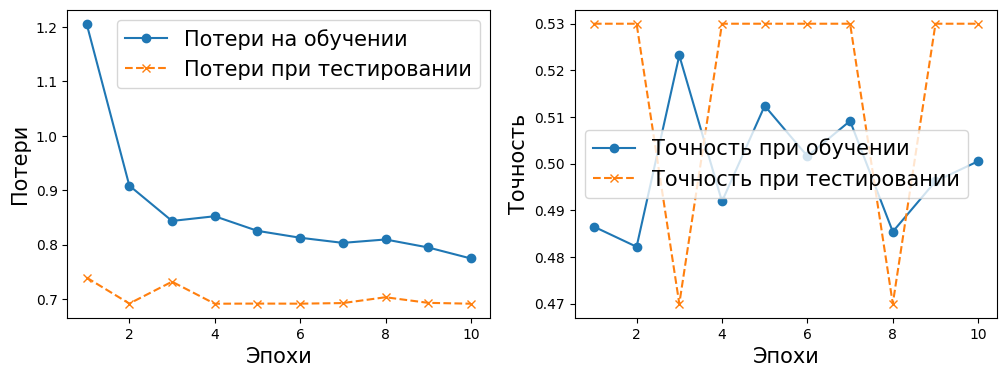

In [65]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Потери на обучении')
ax.plot(x_arr, hist['val_loss'], '--x', label='Потери при тестировании')
ax.set_xlabel('Эпохи', size=15)
ax.set_ylabel('Потери', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Точность при обучении')
ax.plot(x_arr, hist['val_accuracy'], '--x', label='Точность при тестировании')
ax.legend(fontsize=15)
ax.set_xlabel('Эпохи', size=15)
ax.set_ylabel('Точность', size=15)
plt.show()

In [66]:
test_results = model.evaluate(mnist_test.batch(20))
print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

13/13 [==============================] - 1s 102ms/step - loss: 0.6944 - accuracy: 0.5000

Test Acc. 50.00%


TensorShape([15, 10])
tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(15,), dtype=int64)


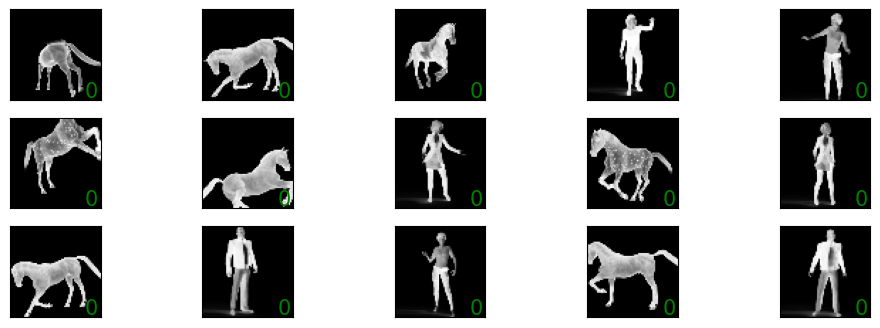

In [67]:
batch_test = next(iter(mnist_test.batch(15)))
preds = model(batch_test[0])
tf.print(preds.shape)
preds = tf.argmax(preds, axis=1)
print(preds)
fig = plt.figure(figsize=(12, 4))
for i in range(15):
 ax = fig.add_subplot(3, 5, i+1)
 ax.set_xticks([]); ax.set_yticks([])
 img = batch_test[0][i, :, :, 0]
 ax.imshow(img, cmap='gray_r')
 ax.text(0.9, 0.1, '{}'.format(preds[i]),
 size=15, color='green',
 horizontalalignment='center',
 verticalalignment='center',
 transform=ax.transAxes)
plt.show()

In [ ]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Потери на обучении')
ax.plot(x_arr, hist['val_loss'], '--x', label='Потери при тестировании')
ax.set_xlabel('Эпохи', size=15)
ax.set_ylabel('Потери', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Точность при обучении')
ax.plot(x_arr, hist['val_accuracy'], '--x', label='Точность при тестировании')
ax.legend(fontsize=15)
ax.set_xlabel('Эпохи', size=15)
ax.set_ylabel('Точность', size=15)
plt.show()

In [80]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
 loss=tf.keras.losses.SparseCategoricalCrossentropy(),
 metrics=['accuracy'])
print(len(mnist_valid))
history = model.fit(mnist_train, epochs=EPOCHS,
 validation_data=mnist_valid,
 shuffle=True)

4
Epoch 1/10
29/29 [==============================] - 27s 871ms/step - loss: 0.7470 - accuracy: 0.6915 - val_loss: 0.1684 - val_accuracy: 0.9500
Epoch 2/10
29/29 [==============================] - 26s 894ms/step - loss: 0.1473 - accuracy: 0.9504 - val_loss: 0.0940 - val_accuracy: 0.9700
Epoch 3/10
29/29 [==============================] - 25s 864ms/step - loss: 0.0823 - accuracy: 0.9763 - val_loss: 0.0502 - val_accuracy: 0.9900
Epoch 4/10
29/29 [==============================] - 25s 873ms/step - loss: 0.0872 - accuracy: 0.9633 - val_loss: 0.1572 - val_accuracy: 0.9200
Epoch 5/10
29/29 [==============================] - 25s 849ms/step - loss: 0.0620 - accuracy: 0.9817 - val_loss: 0.0423 - val_accuracy: 0.9900
Epoch 6/10
29/29 [==============================] - 26s 883ms/step - loss: 0.0326 - accuracy: 0.9892 - val_loss: 0.0258 - val_accuracy: 0.9900
Epoch 7/10
29/29 [==============================] - 26s 887ms/step - loss: 0.0247 - accuracy: 0.9957 - val_loss: 0.0184 - val_accuracy: 1.00

In [73]:
test_results = model.evaluate(mnist_test.batch(20))
print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

13/13 [==============================] - 2s 122ms/step - loss: 6.2829 - accuracy: 0.0000e+00

Test Acc. 0.00%


TensorShape([15, 2560])
tf.Tensor(
[1590  930 1340  570  571 1100 1741  890 1960   71 2120 1010  561  760
 1020], shape=(15,), dtype=int64)


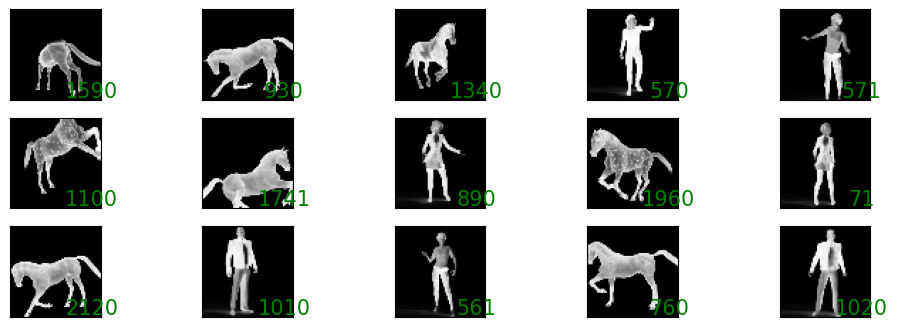

In [74]:
batch_test = next(iter(mnist_test.batch(15)))
preds = model(batch_test[0])
tf.print(preds.shape)
preds = tf.argmax(preds, axis=1)
print(preds)
fig = plt.figure(figsize=(12, 4))
for i in range(15):
 ax = fig.add_subplot(3, 5, i+1)
 ax.set_xticks([]); ax.set_yticks([])
 img = batch_test[0][i, :, :, 0]
 ax.imshow(img, cmap='gray_r')
 ax.text(0.9, 0.1, '{}'.format(preds[i]),
 size=15, color='green',
 horizontalalignment='center',
 verticalalignment='center',
 transform=ax.transAxes)
plt.show()

1. **Для решения каких задач используются сверточные нейронные сети?**

   Сверточные нейронные сети (CNN, Convolutional Neural Networks) используются преимущественно для задач обработки изображений и видео. Основные задачи включают:
   - **Классификация изображений**: Определение, к какому классу относится изображение (например, распознавание объектов).
   - **Сегментация изображений**: Разделение изображения на сегменты, каждый из которых соответствует определённому объекту или фону (например, разделение изображения на области дороги и обочины для автономных автомобилей).
   - **Обнаружение объектов**: Определение координат объектов на изображении и их классификация (например, обнаружение лиц или автомобилей на изображении).
   - **Распознавание лиц**: Идентификация и верификация лиц на изображениях или видео.
   - **Обработка текста и языка**: Применение для задач обработки естественного языка, таких как анализ тональности и машинный перевод.

2. **Какие функции активации слоев Вы знаете?**

   Существует множество функций активации, используемых в нейронных сетях. Наиболее распространенные включают:
   - **Sigmoid**
   - **Tanh (Hyperbolic Tangent)**
   - **ReLU (Rectified Linear Unit)**
   - **Leaky ReLU**
   - **ELU (Exponential Linear Unit)**
   - **Softmax**
   - **Swish**

3. **С чем связано частое использование в качестве активации последнего уровня классификационной сети функции Softmax? Поясните свой ответ.**

   Функция Softmax часто используется на последнем уровне классификационной сети по следующим причинам:
   - **Интерпретация в виде вероятностей**: Softmax преобразует выходные значения сети в вероятности, которые суммируются до 1. Это позволяет интерпретировать каждый выходной нейрон как вероятность принадлежности к соответствующему классу.
   - **Нормализация**: Softmax масштабирует логиты (сырые выходные значения сети) так, что их сумма равна 1, что удобно для задач многоклассовой классификации.
   - **Стабильность вычислений**: При использовании функции потерь, такой как кросс-энтропия (cross-entropy loss), Softmax обеспечивает численную стабильность и эффективность градиентного спуска.
   - **Соответствие задаче**: В задачах многоклассовой классификации (например, распознавание цифр или объектов на изображениях) сеть должна выбрать один из нескольких классов, и Softmax идеально подходит для этого.
